In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 11.1MB/s 
     |████████████████████████████████| 1.2MB 39.5MB/s 
     |████████████████████████████████| 194kB 40.2MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
Mounted at /content/gdrive


# Der Trainingsprozess

Unser Aktualisierungsschritt lautet:
```python
new_weight = weight - lr * weight.grad
```


## Baseline

In [4]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [5]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [6]:
def get_learner(**kwargs):
    return cnn_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

In [7]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.552988,1.879016,0.368917,00:29
1,2.150225,2.809772,0.338089,00:28
2,1.835421,1.534056,0.499363,00:28


In [8]:
learn = get_learner(opt_func=SGD)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=9.12010818865383e-07)

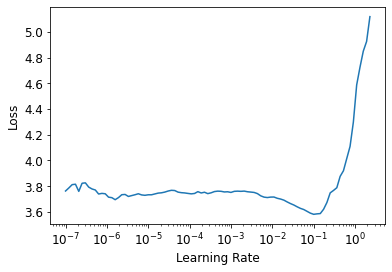

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(3, 0.03, moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,2.956509,2.972102,0.255032,00:26
1,2.404347,1.920101,0.393121,00:26
2,2.136454,1.652521,0.445350,00:26


## Ein allgemeiner Optimizer

```python
def zero_grad(self):
    for p,*_ in self.all_params():
        p.grad.detach_()
        p.grad.zero_()

def step(self):
    for p,pg,state,hyper in self.all_params():
        for cb in self.cbs:
            state = _update(state, cb(p, **{**state, **hyper}))
        self.state[p] = state
```


In [11]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

In [12]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

In [13]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.593077,1.888844,0.343185,00:26
1,2.117987,1.712827,0.414777,00:26
2,1.849695,1.644277,0.446369,00:26


## Momentum

```python
weight.avg = beta * weight.avg + (1-beta) * weight.grad
new_weight = weight - lr * weight.avg
```

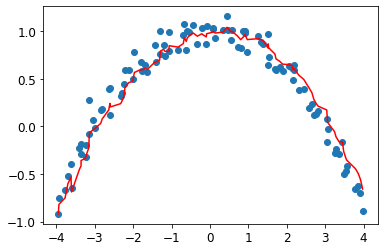

In [14]:
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
plt.scatter(x1,y1)
idx = x1.argsort()
beta,avg,res = 0.7,0,[]
for i in idx:
    avg = beta * avg + (1-beta) * y1[i]
    res.append(avg/(1-beta**(i+1)))
plt.plot(x1[idx],np.array(res), color='red');

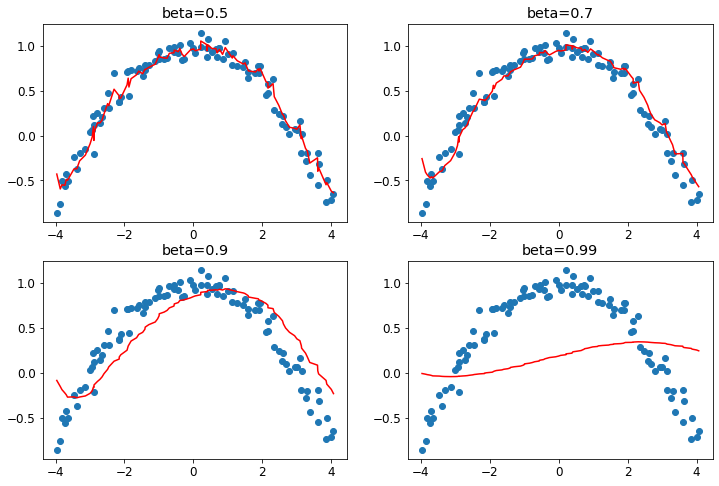

In [15]:
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
idx = x1.argsort()
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(x1,y1)
    avg,res = 0,[]
    for i in idx:
        avg = beta * avg + (1-beta) * y1[i]
        res.append(avg)#/(1-beta**(i+1)))
    ax.plot(x1[idx],np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [16]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + p.grad.data}

In [17]:
def momentum_step(p, lr, grad_avg, **kwargs): p.data.add_(-lr, grad_avg)

In [18]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

In [19]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.778450,2.972757,0.205605,00:27
1,2.410200,2.237068,0.362548,00:27
2,2.108919,1.680781,0.443567,00:27


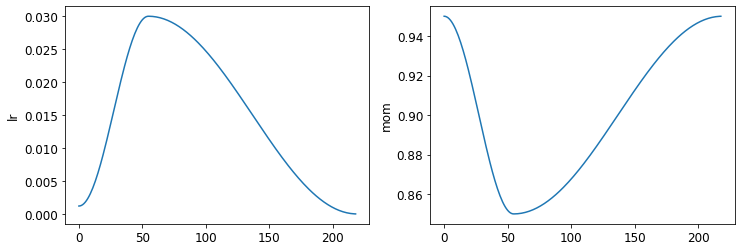

In [20]:
learn.recorder.plot_sched()

## RMS Prop

In [21]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom)*p.grad.data**2}

In [22]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

In [23]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.880217,2.129568,0.223439,00:28
1,2.310198,1.902088,0.349045,00:28
2,1.853434,1.565853,0.474395,00:28


## Ein eigenes Callback erstellen

* `begin_fit::` Initiales Setup. Wird vor allem Anderen ausgeführt.
* `begin_epoch::` Wird zu Beginn jedes Trainingsdurchlaufs (epoch) ausgeführt. Sinnvoll, wenn man bestimmte Eigenschaften zu Beginn der Trainingsiteration zurücksetzen möchte.
* `begin_train::` Wird zu Beginn der Trainingsphase jeder Iteration (epoch) aufgerufen.
* `begin_batch::` Wird zu Beginn jedes Batches ausgeführt. Sinnvoll für Setup in Bezug auf Batches. (zB. hyperparameter scheduling) bzw. Veränderungen an Input- und Outputdaten bevor diese durch das Modell geleitet werden. (zB. Mixup).
* `after_pred::` Wird aufgerufen, nachdem das Ergebnis eines Batches feststeht. Kann verwendet werden, um diese Ausgabe zu verändern, bevor sie in die Loss-Funktion kommt.
* `after_loss::` Wird aufgerufen, nachdem der Loss-Wert berechnet wurde, jedoch vor dem Backward-Pass. Hier kann zB. ein Penalty-Wert auf den Loss-Wert angewendet werden.
* `after_backward::` Wird nach dem Backward-Pass aber vor der Aktualisierung der Gewichte aufgerufen. Zusätzliche Änderungen an den Werten der Gradienten sind hier möglich (zB gradient clipping).
* `after_step::` Wird nach der `step`-Funktion, jedoch vor dem Zurücksetzen der Gradienten aufgerufen.
* `after_batch::` Wird am Ende jedes Batches aufgerufen.
* `after_train::` Wird am Ende der Trainingsphase einer Iteration (epoch) aufgerufen.
* `begin_validate::` Wird zu Beginn der Validierungsphase aufgerufen. Kann für jegliches Setup der Validierung verwendet werden.
* `after_validate::` Wird am Ende der Validierungsphase einer Iteration (epoch) aufgerufen.
* `after_epoch::` Wird am Ende jeder Iteration (epoch) aufgerufen.
* `after_fit::` Wird am Ende des Trainingsvorgangs aufgerufen.


In [ ]:
class ModelResetter(Callback):
    def begin_train(self):    self.model.reset()
    def begin_validate(self): self.model.reset()

In [ ]:
class RNNRegularizer(Callback):
    def __init__(self, alpha=0., beta=0.): self.alpha,self.beta = alpha,beta

    def after_pred(self):
        self.raw_out,self.out = self.pred[1],self.pred[2]
        self.learn.pred = self.pred[0]

    def after_loss(self):
        if not self.training: return
        if self.alpha != 0.:
            self.learn.loss += self.alpha * self.out[-1].float().pow(2).mean()
        if self.beta != 0.:
            h = self.raw_out[-1]
            if len(h)>1:
                self.learn.loss += self.beta * (h[:,1:] - h[:,:-1]
                                               ).float().pow(2).mean()

Innerhalb der Definition eines Callbacks können wir auf folgende Eigenschaften zugreifen:


* `model::` The model used for training/validation.
* `data::` The underlying DataLoaders.
* `loss_func::` The loss function used.
* `opt::` The optimizer used to update the model parameters.
* `opt_func::` The function used to create the optimizer.
* `cbs::` The list containing all the Callbacks.
* `dl::` The current DataLoader used for iteration.
* `x/xb::` The last input drawn from self.dl (potentially modified by callbacks). xb is always a tuple (potentially with one element) and x is detuplified. You can only assign to xb.
* `y/yb::` The last target drawn from self.dl (potentially modified by callbacks). yb is always a tuple (potentially with one element) and y is detuplified. You can only assign to yb.
* `pred::` The last predictions from self.model (potentially modified by callbacks).
* `loss::` The last computed loss (potentially modified by callbacks).
* `n_epoch::` The number of epochs in this training.
* `n_iter::` The number of iterations in the current self.dl.
* `epoch::` The current epoch index (from 0 to n_epoch-1).
* `iter::` The current iteration index in self.dl (from 0 to n_iter-1).

Folgende Attribute wurden durch das `TrainEvalCallback` hinzugefügt:

* `train_iter::` The number of training iterations done since the beginning of this training
* `pct_train::` The percentage of training iterations completed (from 0. to 1.)
* `training::` A flag to indicate whether or not we're in training mode

Folgende Attribute wurden durch `Recorder` hinzugefügt:

* `smooth_loss::` An exponentially averaged version of the training loss


## Reihenfolge von Callbacks

In [ ]:
class TerminateOnNaNCallback(Callback):
    run_before=Recorder
    def after_batch(self):
        if torch.isinf(self.loss) or torch.isnan(self.loss):
            raise CancelFitException

Mögliche Interrupts für die Trainingsschleife in fastai lauten:


* `CancelBatchException::` Überspringe des Rest des Batches und setze mit `after_batch` fort.
* `CancelTrainException::` Überspringe des Rest des Trainings der aktuellen Iteration (epoch) und setze mit `after_train` fort.
* `CancelValidException::` Überspringe des Rest der Validierung der aktuellen Trainingsiteration (epoch) und mit setze mit `after_validate` fort.
* `CancelEpochException::` Überspringe den Rest der aktuellen Trainingsiteration (epoch) und setze mit `after_epoch` fort.
* `CancelFitException::` Unterbreche den Trainingsprozess und setze mit `after_fit` fort.

Natürlich können wir auch diese Ausnahmen lauschen und entsprechenden Code implementieren, der genau dann ausgeführt wird, wenn diese Ausnahmen auftreten.


* `after_cancel_batch::` Wird aufgerufen, nachdem eine  `CancelBatchException` aufgetreten ist und bevor mit `after_batch` fortgesetzt wird.
* `after_cancel_train::` Wird aufgerufen, nachdem eine  `CancelTrainException` aufgetreten ist und bevor mit `after_train` fortgesetzt wird.
* `after_cancel_valid::` Wird aufgerufen, nachdem eine  `CancelValidException` aufgetreten ist und bevor mit `after_valid` fortgesetzt wird.
* `after_cancel_epoch::` Wird aufgerufen, nachdem eine  `CancelEpochException` aufgetreten ist und bevor mit `after_epoch` fortgesetzt wird.
* `after_cancel_fit::` Wird aufgerufen, nachdem eine  `CancelFitException` aufgetreten ist und bevor mit `after_fit` fortgesetzt wird.

Wenn ein Callback immer vor oder nach einem anderen Callback ausgeführt werden muss, können wir das mithilfe von `run_before` und `run_after` innerhalb der Definition des Callbacks durchführen.